## install required libraries

In [1]:
%%capture
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

!apt-get install -y tesseract-ocr
!pip install pytesseract

!pip install datasets
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import required packages

In [3]:
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import pytesseract
from PIL import Image, ImageDraw, ImageFont

import torch
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor, LayoutLMv2ForSequenceClassification, AdamW

## unzip dataset

In [4]:
import zipfile
compressed_dataset_path = "/content/drive/MyDrive/doc_classification/dataset.zip"

# Replace 'your_dataset.zip' with the actual name of your zip file.
with zipfile.ZipFile(compressed_dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
dataset_path = "/content/dataset/images/"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'0': 0, '2': 1, '9': 2, '6': 3, '4': 4}

In [6]:
# Initialize empty lists to store image paths and labels.
images = []
labels = []

# Loop through each label (subdirectory) in the dataset path.
for label in os.listdir(dataset_path):
    # Extend the images list with the full image paths by combining dataset_path, label, and image names.
    images.extend([
        f"{dataset_path}/{label}/{img_name}" for img_name in os.listdir(f"{dataset_path}/{label}")
    ])
    # Extend the labels list with the label name for each image in the current label directory.
    labels.extend([
        label for _ in range(len(os.listdir(f"{dataset_path}/{label}")))
    ])

# Create a Pandas DataFrame 'data' containing image paths and corresponding labels.
data = pd.DataFrame({'image_path': images, 'label': labels})

# Split the data into training and validation sets using train_test_split from scikit-learn.
train_data, valid_data = train_test_split(data, test_size=0.15, random_state=0, stratify=data.label)

# Reset the indices of both DataFrames for convenience.
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

print(f"{len(train_data)} training examples, {len(valid_data)} validation examples")
data.head()

2125 training examples, 375 validation examples


,image_path,label
0,/content/dataset/images//0/64f6ceac-2989-447e-...,0
1,/content/dataset/images//0/0d1d224a-7f2f-4a92-...,0
2,/content/dataset/images//0/2e809826-6ab9-4d19-...,0
3,/content/dataset/images//0/cd2ff1e9-2344-43c7-...,0
4,/content/dataset/images//0/96f425b2-432a-4c97-...,0


## Data Preparation

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def encode_training_example(examples):
    """Encodes a batch of training examples for a deep learning model.
    Parameters:
        examples (pd.DataFrame): A DataFrame containing image paths and labels.

    Returns:
        dict: A dictionary containing the encoded inputs and labels.
    """
    # Load images and convert them to RGB format using PIL's Image.open().
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]

    # Process the images using the specified processor, which includes tokenization and padding.
    encoded_inputs = processor(images, padding="max_length", truncation=True)

    # Map labels to their corresponding indices and add them to the encoded_inputs dictionary.
    encoded_inputs["labels"] = [label2idx[label] for label in examples["label"]]

    return encoded_inputs


# Define the features expected by the model for training.
training_features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),  # RGB image with shape (3, 224, 224).
    'input_ids': Sequence(feature=Value(dtype='int64')),  # Tokenized input IDs for the model.
    'attention_mask': Sequence(Value(dtype='int64')),  # Attention mask for the input.
    'token_type_ids': Sequence(Value(dtype='int64')),  # Token type IDs for the input.
    'bbox': Array2D(dtype="int64", shape=(512, 4)),  # Bounding box coordinates (if required).
    'labels': ClassLabel(num_classes=len(label2idx), names=list(label2idx.keys())),  # Labels as class indices.
})

In [9]:
def dataloader_from_df(data):
    """Create a DataLoader from a pandas DataFrame containing image paths and labels.
    This function processes the DataFrame and prepares the data for training by
    encoding the images and mapping labels to their corresponding indices. The DataLoader
    allows easy iteration over batches during the training process.

    Parameters:
        data (pd.DataFrame): A DataFrame containing image paths and labels.

    Returns:
        torch.utils.data.DataLoader: A DataLoader object that provides batches of training data.
    """

    # Convert the DataFrame to a Hugging Face Dataset.
    dataset = Dataset.from_pandas(data)

    # Encode the images and labels in the dataset using the specified features and processor.
    encoded_dataset = dataset.map(
        encode_training_example, remove_columns=dataset.column_names, features=training_features,
        batched=True, batch_size=2
    )

    # Set the format of the encoded dataset to be compatible with PyTorch.
    encoded_dataset.set_format(type='torch', device=device)

    # Create a DataLoader from the encoded dataset, specifying the batch size and shuffle option.
    dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4, shuffle=True)

    # Retrieve and discard the first batch to avoid any potential initialization issues.
    batch = next(iter(dataloader))

    return dataloader

In [10]:
# a LayoutLMv2FeatureExtractor to extract image and layout features.
feature_extractor = LayoutLMv2FeatureExtractor()

# a LayoutLMv2Tokenizer from the "microsoft/layoutlmv2-base-uncased" pretrained model.
# The tokenizer is used to convert the input data into model-compatible token representations.
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")

# a LayoutLMv2Processor that combines the feature extractor and tokenizer.
# The processor handles image encoding and tokenization for the LayoutLMv2 model.
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [ ]:
# a DataLoader for the training data using the provided train_data DataFrame.
# The dataloader_from_df function encodes the images and labels, and prepares batches for training.
train_dataloader = dataloader_from_df(train_data)

# a DataLoader for the validation data using the provided valid_data DataFrame.
# The dataloader_from_df function encodes the images and labels, and prepares batches for validation.
valid_dataloader = dataloader_from_df(valid_data)

## Building Model

In [ ]:
# a LayoutLMv2ForSequenceClassification model from the "microsoft/layoutlmv2-base-uncased" pretrained model.
# The model is initialized with the specified number of output labels, which is equal to the length of label2idx dictionary.
model = LayoutLMv2ForSequenceClassification.from_pretrained(
    "microsoft/layoutlmv2-base-uncased",  num_labels=len(label2idx)
)
model.to(device);

Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training

In [ ]:
def train_model(model, dataloader, optimizer):
    """Train the model on the provided data using the specified optimizer.
    Parameters:
        model (LayoutLMv2ForSequenceClassification): The model to be trained.
        dataloader (torch.utils.data.DataLoader): DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.

    Returns:
        tuple: A tuple containing the training loss and accuracy for the current epoch.
    """
    # Initialize variables to track training loss and correct predictions.
    training_loss = 0.0
    training_correct = 0

    # Set the model in training mode to enable gradient computation.
    model.train()

    # Iterate through each batch in the DataLoader.
    for batch in tqdm(dataloader):
        # Forward pass through the model and compute the loss.
        outputs = model(**batch)
        loss = outputs.loss

        # Accumulate the training loss and count the number of correct predictions.
        training_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        training_correct += (predictions == batch['labels']).float().sum()

        # Backpropagate the gradients and update model parameters.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Compute the average training loss per data point and the training accuracy in percentage.
    training_loss = training_loss / batch["input_ids"].shape[0]
    training_accuracy = 100 * training_correct / len(train_data)

    return training_loss, training_accuracy

def validate_model(model, dataloader):
    """Validate the model on the provided data.
    Parameters:
        model (LayoutLMv2ForSequenceClassification): The model to be validated.
        dataloader (torch.utils.data.DataLoader): DataLoader containing the validation data.

    Returns:
        tuple: A tuple containing the validation loss and accuracy for the current epoch.
    """
    # Initialize variables to track validation loss and correct predictions.
    validation_loss = 0.0
    validation_correct = 0

    # Set the model in evaluation mode to disable gradient computation.
    model.eval()

    # Iterate through each batch in the DataLoader.
    for batch in tqdm(dataloader):
        # Forward pass through the model and compute the loss.
        outputs = model(**batch)
        loss = outputs.loss

        # Accumulate the validation loss and count the number of correct predictions.
        validation_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        validation_correct += (predictions == batch['labels']).float().sum()

    # Compute the average validation loss per data point and the validation accuracy in percentage.
    validation_loss = validation_loss / batch["input_ids"].shape[0]
    validation_accuracy = 100 * validation_correct / len(valid_data)

    return validation_loss, validation_accuracy


# Define the optimizer and learning rate for training.
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the number of epochs for training.
num_epochs = 5

# Start the training process by iterating through each epoch.
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")

    # Train the model on the training data for the current epoch and obtain training loss and accuracy.
    training_loss, training_accuracy = train_model(model, train_dataloader, optimizer)
    print(f"Training Loss: {training_loss} Training Accuracy: {training_accuracy.item()}")

    # Validate the model on the validation data for the current epoch and obtain validation loss and accuracy.
    validation_loss, validation_accuracy = validate_model(model, valid_dataloader)
    print(f"Validation Loss: {validation_loss} Validation Accuracy: {validation_accuracy.item()}")

Epoch: 0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/532 [00:00<?, ?it/s]

Training Loss: 317.56509515084326 Training Accuracy: 79.76470947265625


  0%|          | 0/94 [00:00<?, ?it/s]

Validation Loss: 22.42807040611903 Validation Accuracy: 78.4000015258789
Epoch: 1


  0%|          | 0/532 [00:00<?, ?it/s]

Training Loss: 221.64237106125802 Training Accuracy: 86.77647399902344


  0%|          | 0/94 [00:00<?, ?it/s]

Validation Loss: 17.346787423516314 Validation Accuracy: 82.66666412353516
Epoch: 2


  0%|          | 0/532 [00:00<?, ?it/s]

Training Loss: 190.71198049839586 Training Accuracy: 88.84706115722656


  0%|          | 0/94 [00:00<?, ?it/s]

Validation Loss: 14.801868114620447 Validation Accuracy: 87.19999694824219
Epoch: 3


  0%|          | 0/532 [00:00<?, ?it/s]

Training Loss: 134.4939755955711 Training Accuracy: 91.95294189453125


  0%|          | 0/94 [00:00<?, ?it/s]

Validation Loss: 14.751575911262384 Validation Accuracy: 87.73332977294922
Epoch: 4


  0%|          | 0/532 [00:00<?, ?it/s]

Training Loss: 125.6878606567625 Training Accuracy: 92.32941436767578


  0%|          | 0/94 [00:00<?, ?it/s]

Validation Loss: 15.597872433097413 Validation Accuracy: 86.93333435058594


## confusion matrix

  0%|          | 0/94 [00:00<?, ?it/s]

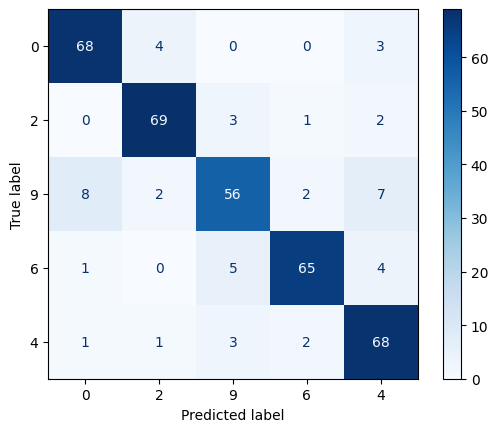

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Put the model in evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Make predictions on the validation dataset
with torch.no_grad():
    for batch in tqdm(valid_dataloader):
        outputs = model(**batch)
        logits = outputs.logits
        predictions = logits.argmax(dim=-1)

        true_labels.extend(batch["labels"].tolist())
        predicted_labels.extend(predictions.tolist())

# Convert the lists to numpy arrays for confusion matrix calculation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label2idx)  # Replace class labels accordingly
display.plot(cmap='Blues', values_format='d')

## f1-score, precision & recall

In [ ]:
from sklearn.metrics import f1_score

num_classes = 5

# Calculate precision, recall, and F1 score for each class
class_precision = np.zeros(num_classes)
class_recall = np.zeros(num_classes)
class_f1 = np.zeros(num_classes)

for i in range(num_classes):
    class_precision[i] = cm[i, i] / np.sum(cm[:, i])  # True Positives / (True Positives + False Positives)
    class_recall[i] = cm[i, i] / np.sum(cm[i, :])  # True Positives / (True Positives + False Negatives)
    class_f1[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])

# Calculate macro-averaged F1 score
macro_f1 = np.mean(class_f1)

print("Class Precision:", class_precision)
print("Class Recall:", class_recall)
print("Class F1 Score:", class_f1)
print("Macro-Averaged F1 Score:", macro_f1)

Class Precision: [0.87179487 0.90789474 0.8358209  0.92857143 0.80952381]
Class Recall: [0.90666667 0.92       0.74666667 0.86666667 0.90666667]
Class F1 Score: [0.88888889 0.91390728 0.78873239 0.89655172 0.85534591]
Macro-Averaged F1 Score: 0.868685240822183


## inference

In [31]:
def infer(image, label2idx, model, processor):
  # prepare image for the model
  encoded_inputs = processor(image, return_tensors="pt").to(device)

  # Run the inference using the model
  with torch.no_grad():
      outputs = model(**encoded_inputs)

  # Calculate the probabilities for each class
  preds = torch.softmax(outputs.logits, dim=1).tolist()[0]
  pred_labels = {label: pred for label, pred in zip(label2idx.keys(), preds)}

  # Get the predicted class label with the highest likelihood rate
  predicted_class_idx = max(pred_labels, key=pred_labels.get)

  return predicted_class_idx

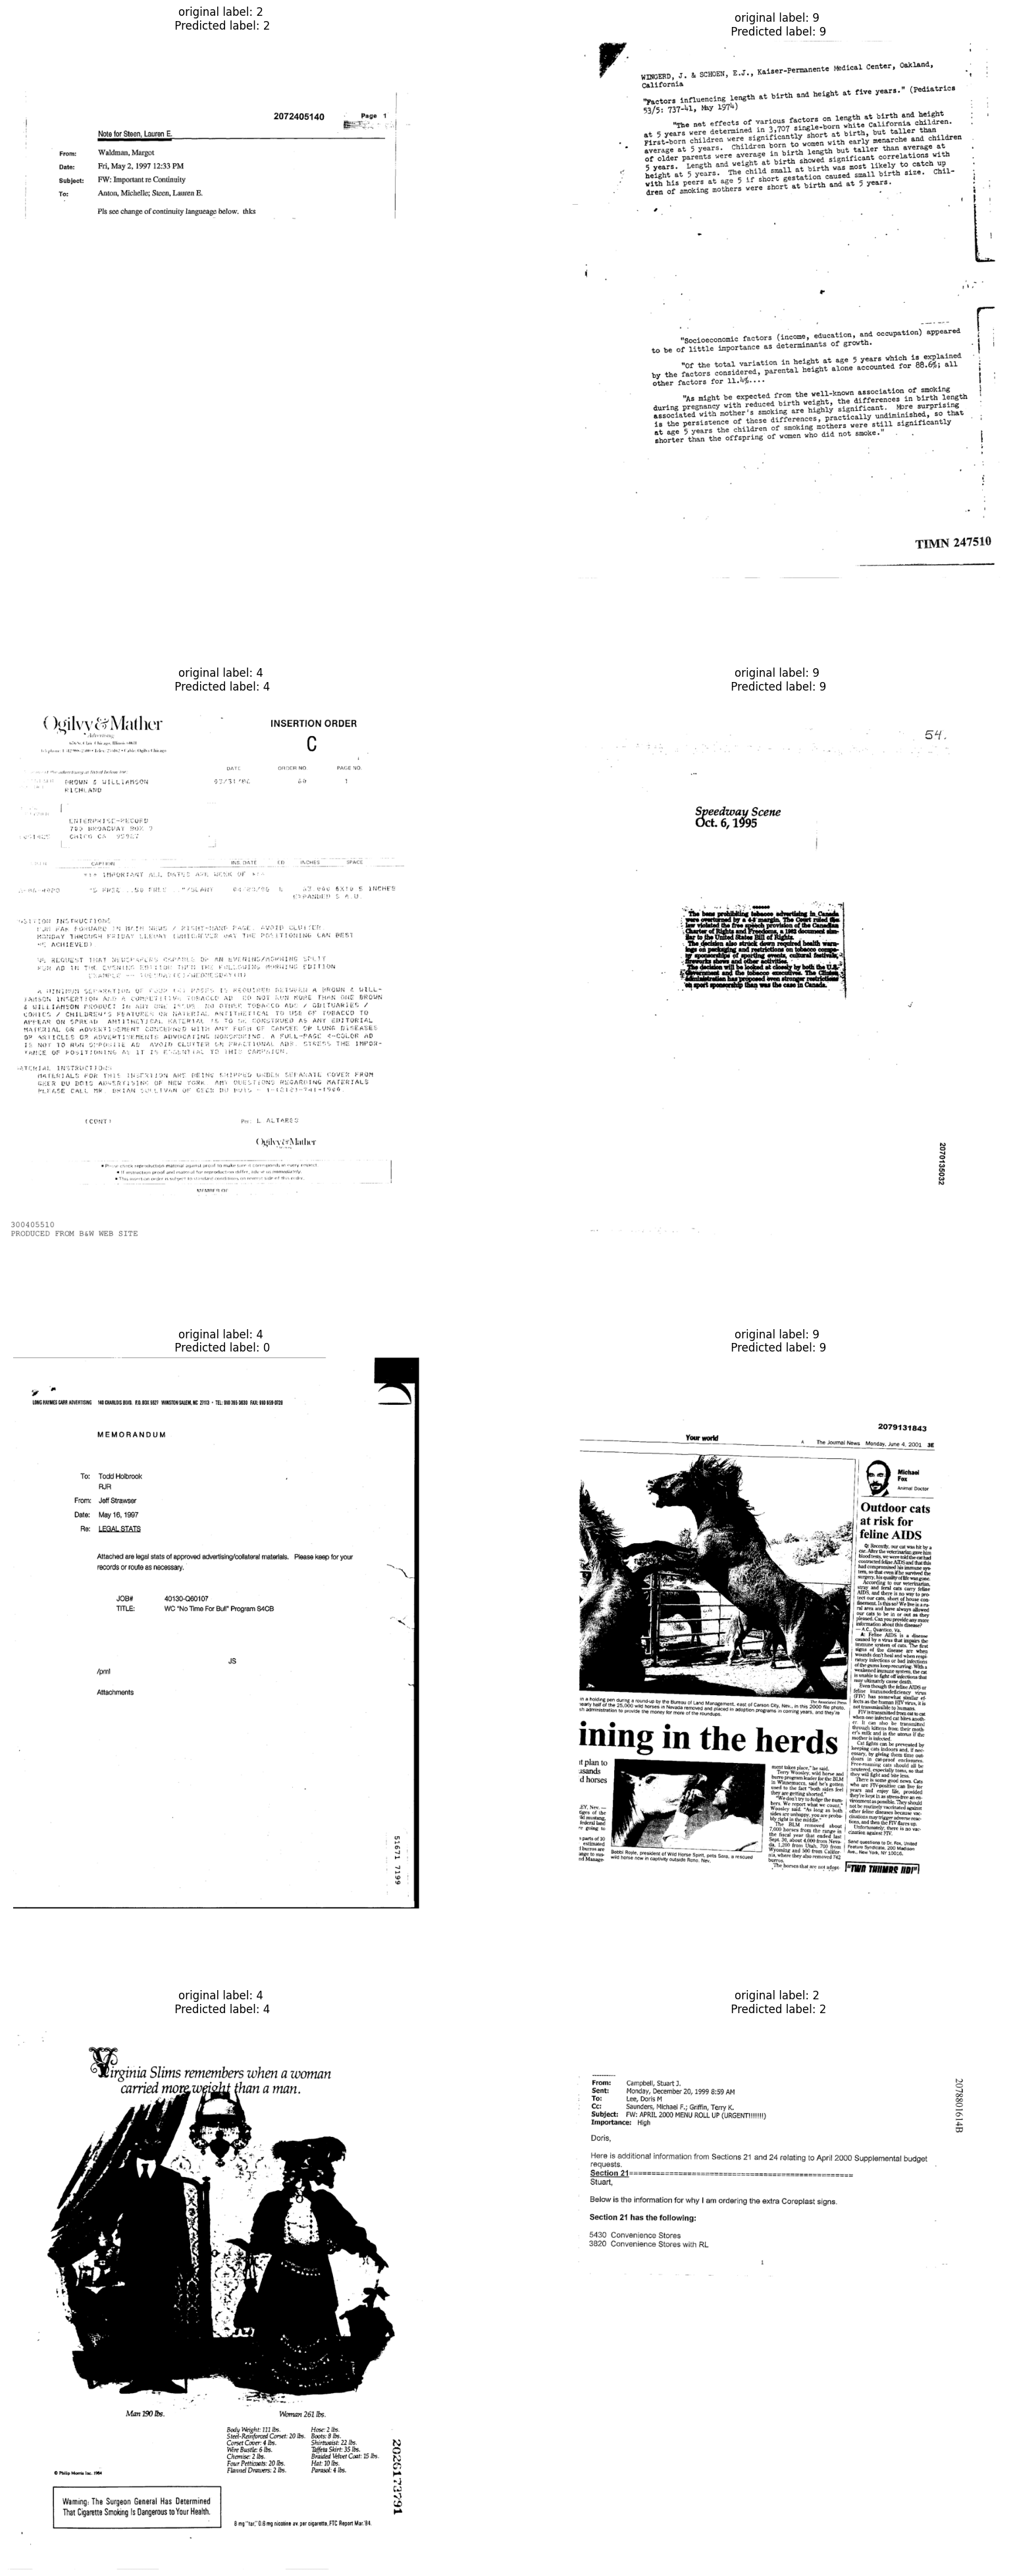

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

num_test = 8
cnt = 1

plt.figure(figsize=(20, 50))

# Define the spacing between subplots
hspace = 0.2  # Vertical spacing
wspace = 0.2 # Horizontal spacing

plt.subplots_adjust(hspace=hspace, wspace=wspace)

while cnt <= num_test:
    k = np.random.randint(len(valid_data))
    label = valid_data.label.iloc[k]

    image = Image.open(valid_data.image_path.iloc[k]).convert("RGB")
    try:
        pred = infer(image, label2idx, model, processor)
    except Exception as e:
        continue

    plt.subplot(int(num_test / 2), 2, cnt)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"original label: {label}\n Predicted label: {pred}")
    cnt += 1

plt.show()


## saving model

In [ ]:
# Saving the model
model.save_pretrained('/content/drive/MyDrive/models')

In [12]:
# loading the model
model_path = "/content/drive/MyDrive/doc_classification/models/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForSequenceClassification.from_pretrained(model_path)
model.to(device);